# Exercise 1: Backpropagation für Mehrschichtperzeptronen

## Table of Contents
- [1.1 Datensatz generieren](#11-datensatz-generieren)
- [1.2 Labels zuweisen](#12-labels-zuweisen)
- [1.6 Designmatritzen für transformierte Eingaben erstellen](#16-designmatritzen-für-transformierte-eingaben-erstellen)

## 1. Spielzeugdatensatz

Laden Sie sich das Jupyter-Notebook ”Training eines MLPs auf MNIST” von der Vorlesungsseite auf Moodle herunter, das den Numpy-Code für den Backpropagation-Algorithmus für MLPs enthält. Statt auf MNIST werden wir zunächst ein einfacheres Perzeptron auf den Spielzeugdaten aus der Vorlesung trainieren.

### 1.1 Datensatz generieren <a name="11-datensatz-generieren"></a>

Erzeugen Sie 200 zweidimensionale Trainingsdatenpunkte mithilfe einer Gleichverteilung über dem Gebiet [−6, 6]×[−6, 6]. Speichern Sie diese in einer 200×2 Designmatrix

Mittels `np.random` können Zufallszahlen generiert werden, mit dem Zusatz `uniform` können diese aus einer Gleichverteilung gezogen werden.

In [1]:
import numpy as np

# Erstellen der Datenpunkte im vorgegebenen Bereich 
X_train = np.random.uniform(-6, 6, (200, 2))
X_train[:5,:]

array([[ 4.21452788,  2.50411855],
       [-0.72176854, -2.52246837],
       [ 3.07109886,  5.38247869],
       [ 5.57260716,  0.89826285],
       [-2.64415165, -2.90976108]])

### 1.2 Labels zuweisen

Die Klassenlabels 0 und 1 werden so vergeben, dass alle Datenpunkte im 1. und 3.Quadranten das Label 1 und im 2. und 4. Quadranten das Label 0 erhalten. Speichern
Sie die Labels in einem Array

In [2]:
def get_labels(points) -> np.ndarray:
    """
    Assigns labels to points based on their quadrant:
    - Label 1 for Quadrants I and III
    - Label 0 for Quadrants II and IV
    Args:
        points (np.ndarray): Array of shape (n_samples, 2) containing the points.
    Returns:
        np.ndarray: Array of shape (n_samples,) containing the labels.
    """
    labels = []
    for point in points:
        x, y = point
        if x > 0 and y >= 0: # Quadrant I
            labels.append(1)
        elif x <= 0 and y < 0: # Quadrant III
            labels.append(1)
        elif x < 0 and y >= 0: # Quadrant II
            labels.append(0)
        elif x >= 0 and y < 0: # Quadrant IV
            labels.append(0)
        else:
            Exception("Invalid point")
    labels = np.array(labels)
    return labels

y_train = get_labels(X_train)
y_train[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

Die Funktion `get_labels()` wird für die folgenden Aufgabenteile benötigt und wird daher künftig über eine eigene Python File [`auxiliary.py`](auxiliary.py) bereitgestellt.

___

### 1.3 Testdatensatz generieren

Erzeugen Sie einen gleich großen Testdatensatz nach demselben Prinzip. Stellen Sie
beide Datensätze zur Überprüfung als Scatterplot dar.

Hierfür werden die Daten wie zuvor für die Trainingsdaten generiert entsprechend der Quadranten mit unterschiedlichen Farben zugeordnet.

In [3]:
X_test = np.random.uniform(-6, 6, (200, 2))
X_test[:5,:]

array([[-0.47255726, -5.22883125],
       [ 1.79363711, -1.08674627],
       [-5.22994006,  5.05796786],
       [-4.94253937, -4.4850634 ],
       [-3.72878047, -4.58658669]])

In [4]:
y_test = get_labels(X_test)
y_test[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

#### 1.3.1 Visualisierung der Daten

Anschließend lasse sich die Trainings- und Testdaten mit `matplotlib` wie folgt visualisieren:

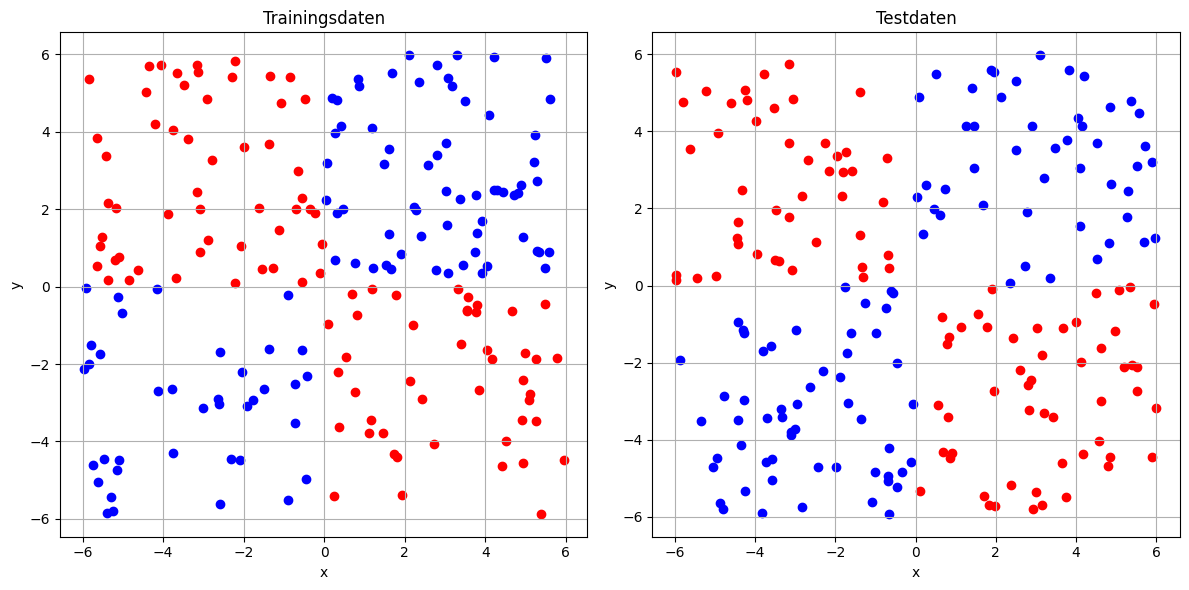

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

# Plot der Trainingsdaten
plt.subplot(1, 2, 1)
plt.title("Trainingsdaten")
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Label 1')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Label 0')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

# Plot der Testdaten
plt.subplot(1, 2, 2)
plt.title("Testdaten")
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='blue', label='Label 1')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='red', label='Label 0')
plt.xlabel("x")
plt.ylabel("y")

plt.grid()
plt.tight_layout()
plt.show()

___

## 1.4 Gewichtsvektoren für die Neuronen definieren
Das in der Vorlesung dargestellte Experiment operiert nicht direkt auf den Inputdaten,
sondern auf 2 Merkmalen, die mithilfe zweier Neuronen mit fixem Gewichtsvektor
berechnet werden: ein Neuron teilt die Inputebene waagrecht entlang der x-Achse, das
andere senkrecht entlang der y-Achse. Wie muss der Gewichtsvektor für das jeweilige
Neuron aussehen?

Das genannte Experiment bezieht sich auf [Beispiel 1](https://playground.tensorflow.org./#activation=tanh&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.65710&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) im TensorFlow Playground.

Das Experiment ist auch in folgender Abbildung dargestellt:
![Experiment nur Eingangsneuronen](./data/experiment_1.png)

Im folgenden werden dementsprechend zwei Gewichtsvektoren definiert `w_x` und `w_y` definiert die diese Trennungsebenen realisieren.

`w_x` bildet dabei einen Punkt $(x, y)$ per Skalarprodukt $\langle w_x, (x, y)\rangle = 1*x + 0*y$ auf die $x$-Koordinate ab, während `w_y` einen Punkt $(x, y)$ per Skalarprodukt $\langle w_y, (x, y)\rangle = 0*x + 1*y$ auf die $y$-Koordinate abbildet.

Da die Ebenen jeweils entlang der $x$- und $y$-Achse verlaufen und die Grenzen nicht verschoben sind, wird kein Bias-Term benötigt.

In [6]:
w_x = np.array([1, 0])
w_y = np.array([0, 1])

print("Gewichtvektor für x-Achse:", w_x)
print("Gewichtvektor für y-Achse:", w_y)

Gewichtvektor für x-Achse: [1 0]
Gewichtvektor für y-Achse: [0 1]


Wie in der Vorlesung erläutert, erhalten wir so einen klassischen linearen Klassifikator, der die Datenpunkte anhand ihrer $x$- und $y$-Koordinaten in die Klassen 0 und 1 einteilt. Das Lernproblem ist jedoch nicht nicht linear trennbar.

___

## 1.5 Entscheidungsfunktion berechnen und darstellen

Berechnen Sie die Entscheidungsfunktion beider Neuron mit der im Beispielcode
angegebenen sigmoiden Aktivierungsfunktion auf einem 100 × 100-Gitter innerhalb
des Gebietes [−6, 6] × [−6, 6] und stellen Sie diese zur Überprüfung als Farbbild dar.

Im ersten Schritt muss ein Gitter für die $x$- und $y$-Koordinaten erzeugt werden. Hierfür werden zuerst zwei Vektoren mit 100 gleichmäßig verteilten Werten im Intervall [−6, 6] erstellt (`xv` und `xy`). Für die Gleichmaßige Verteilung kann die Funktion `np.linspace` verwendet werden.

In [7]:
xv = np.linspace(-6, 6, 100)
yv = np.linspace(-6, 6, 100)

Anschließend wird mit der Funktion `np.meshgrid` aus diesen Vektoren ein Gitter erstellt, das alle Kombinationen von $x$- und $y$-Werten enthält. 

`X` und `Y` sind dabei 2D-Arrays, die die $x$- und $y$-Koordinaten jedes Punkts im Gitter repräsentieren (siehe Shapeausgabe).

In [8]:
X, Y = np.meshgrid(xv, yv)
print("Shape X:", X.shape)
print("Shape Y:", Y.shape)

Shape X: (100, 100)
Shape Y: (100, 100)


Anschließend kann dieses Gitter zur Visualisierung dargestellt werden.

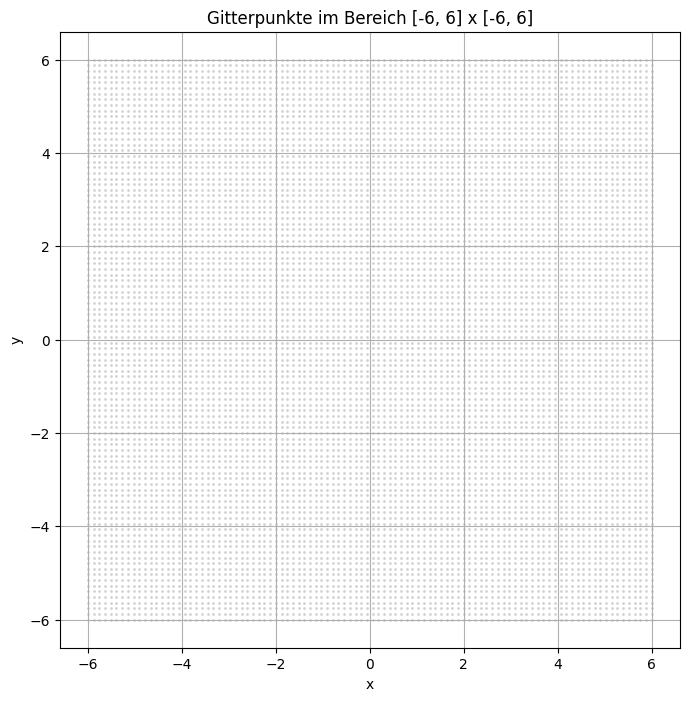

In [9]:
# plot the grid points
plt.figure(figsize=(8, 8))
plt.scatter(X, Y, color='lightgray', s=1)
plt.title("Gitterpunkte im Bereich [-6, 6] x [-6, 6]")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

Da es sich bei `X` und `Y` um 2D-Arrays handelt, müssen diese zunächst in 1D-Vektoren umgeformt werden, damit sie als Eingabe für die Neuronen dienen können. Dies kann mit der Methode `ravel()` erreicht werden (***flatten***).

In [10]:
X_flat = X.ravel()
Y_flat = Y.ravel()
X_flat

array([-6.        , -5.87878788, -5.75757576, ...,  5.75757576,
        5.87878788,  6.        ])

Anschließend können die beiden geflatteten Arrays zu einer Designmatrix kombiniert werden, in der jede Zeile einem Punkt im Gitter entspricht. Die Spalten enthalten die $x$- und $y$-Koordinaten der Punkte.

In [11]:
design = np.c_[X_flat, Y_flat]
design

array([[-6.        , -6.        ],
       [-5.87878788, -6.        ],
       [-5.75757576, -6.        ],
       ...,
       [ 5.75757576,  6.        ],
       [ 5.87878788,  6.        ],
       [ 6.        ,  6.        ]])

Mit der Designmatrix können nun die Aktivierungen (**Voraktivierung**) der beiden Neuronen berechnet werden, indem die Designmatrix (`design`) mit den jeweiligen Gewichtsvektoren (`w_x` & `w_y`) multipliziert wird. Dies entspricht der linearen Transformation, die jedes Neuron auf die Eingabedaten anwendet.

Mathematisch erfolgt hier das was auf Seite 26 bzw. 27 der ersten Vorlesung vermittelt wird:
$$
a^l = \sigma(w^l a^{l-1} + b) \text{    mit    } z^l = w^l a^{l-1} + b
$$
Da es sich um die Eingabeschicht handelt, ist $a^{l-1}$ hier die Designmatrix und es gibt keinen Bias-Term. Damit ergibt sich für die Voraktivierung:
$$
z = w \cdot a^{0}
$$

In [12]:
z_x = design @ w_x   # entspricht x-Koordinate
z_y = design @ w_y   # entspricht y-Koordinate

Dieser Teil entspricht dem linken Teil des in folgender Abbildung beispielhaft dargestellten Abbildung.
![single neuron](./data/single_neuron.drawio.png)

Im folgenden wird der Output dieser Voraktivierung durch die Aktivierungsfunktion (Sigmoid) geleitet, um die endgültigen Aktivierungen der Neuronen zu erhalten.

Die Vorgegebene Aktivierungsfunktion ist im Beispiel [training_eines_MLPs_auf_MNIST.ipynb](./training_eines_MLPs_auf_MNIST.ipynb) definiert.

In [13]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

Diese wird nun auf die linearen Aktivierungen (`z_x` und `z_y`) angewendet, um die nichtlinearen Ausgaben (`a_x` und `a_y`) der Neuronen zu erhalten.

In [14]:
a_x = sigmoid(z_x)   # Werte in (0, 1)
a_y = sigmoid(z_y)   # Werte in (0, 1)
a_x.shape, a_y.shape

((10000,), (10000,))

In [15]:
a_x[:10], a_y[:10]

(array([0.00247262, 0.00279037, 0.00314881, 0.00355314, 0.00400918,
        0.00452348, 0.00510342, 0.00575729, 0.00649438, 0.00732514]),
 array([0.00247262, 0.00247262, 0.00247262, 0.00247262, 0.00247262,
        0.00247262, 0.00247262, 0.00247262, 0.00247262, 0.00247262]))

Bei den beiden Ausgaben `a_x` und `a_y` handelt es sich um die Entscheidungsfunktionen der beiden Neuronen über dem Gitter in 1D-Form. Um diese als Farbbild darzustellen, müssen sie wieder in die ursprüngliche Gitterform (100x100) zurückgebracht werden. Dies kann mit der Methode `reshape` erreicht werden.

In [16]:
decision_x = a_x.reshape(100, 100)
decision_y = a_y.reshape(100, 100)

Anschließend lassen sich die Entscheidungsfunktionen als Farbbilder darstellen.

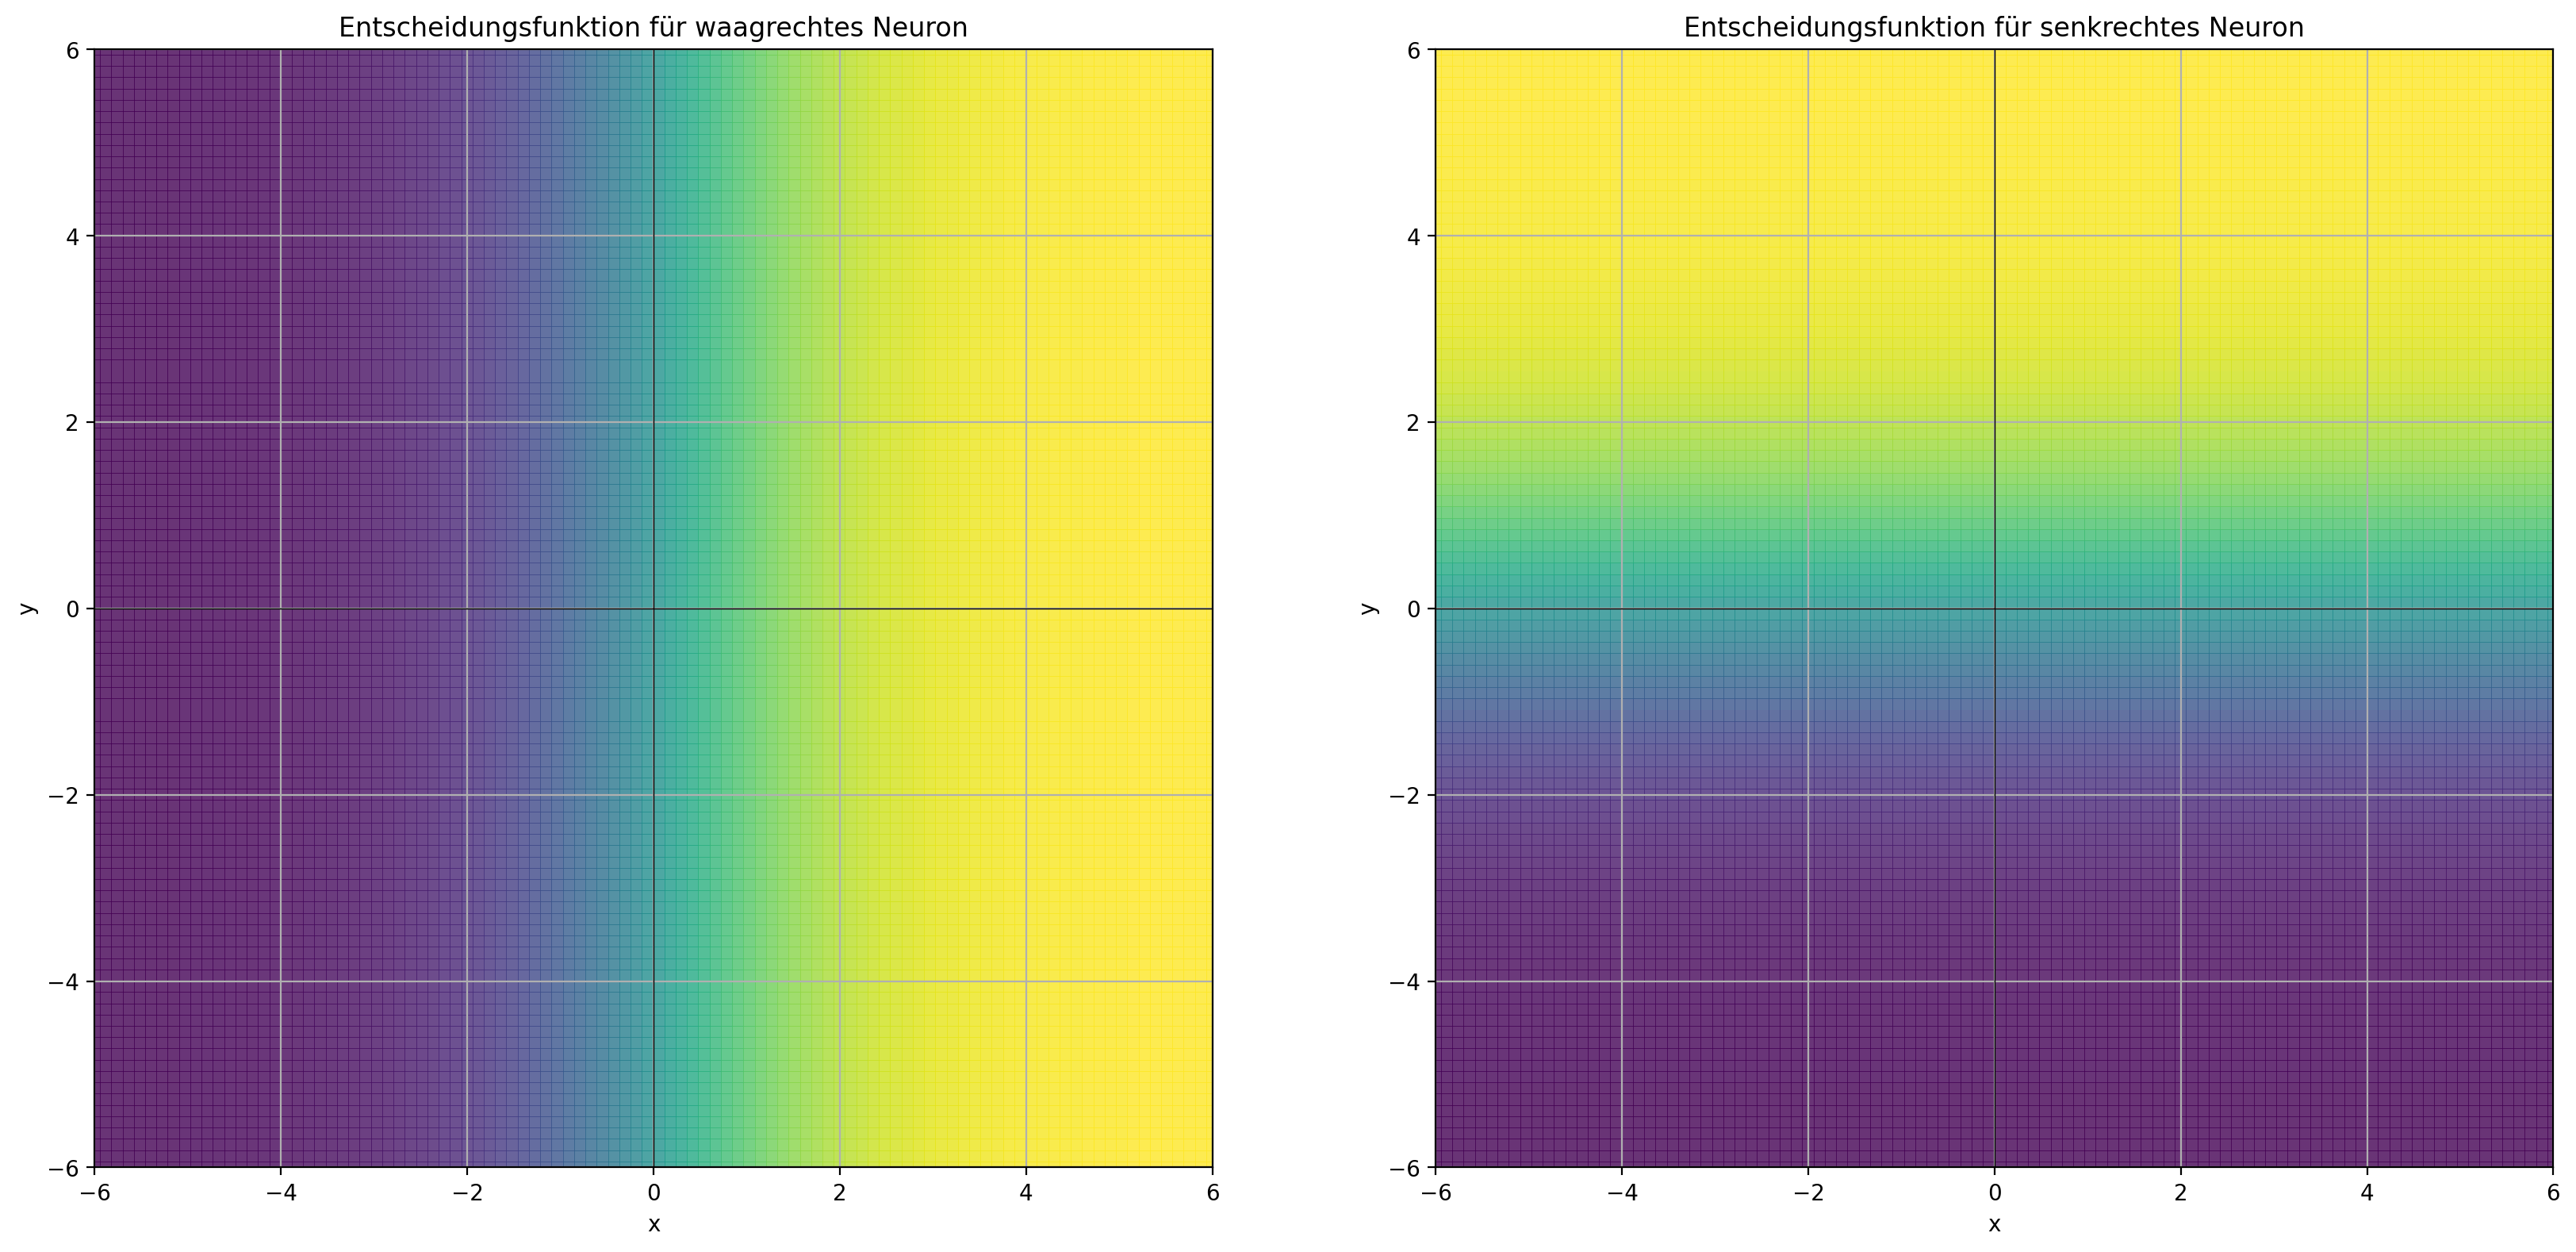

In [17]:
figure, axis = plt.subplots(1, 2, figsize=(20, 20), dpi=200)
axis_limits = [-6, 6]

# Plot für die erste Subplot-Achse
axis[0].pcolor(X, Y, decision_x.reshape(100, 100), alpha=.8)
axis[0].grid(True)
axis[0].set_title("Entscheidungsfunktion für waagrechtes Neuron")
axis[0].set_xlabel("x")
axis[0].set_ylabel("y")
axis[0].axhline(0, color='black', linewidth=0.5)
axis[0].axvline(0, color='black', linewidth=0.5)
axis[0].set_xlim(axis_limits)
axis[0].set_ylim(axis_limits)
axis[0].set_aspect('equal')

# Plot für die zweite Subplot-Achse
axis[1].pcolor(X, Y, decision_y.reshape(100, 100), alpha=.8)
# contour2 = axis[1].contourf(xv, yv, results_senkrechte, levels=50, cmap="viridis")
axis[1].grid(True)
axis[1].set_title("Entscheidungsfunktion für senkrechtes Neuron")
axis[1].set_xlabel("x")
axis[1].set_ylabel("y")
axis[1].axhline(0, color='black', linewidth=0.5)
axis[1].axvline(0, color='black', linewidth=0.5)
axis[1].set_xlim(axis_limits)
axis[1].set_ylim(axis_limits)
axis[1].set_aspect('equal')
plt.show()

____

## 1.6 Designmatritzen für transformierte Eingaben erstellen
Da die Eingangsneuronen nicht mittrainiert werden, können wir deren Output schon
im Vorfeld berechnen. Erzeugen Sie dazu neue Designmatritzen für den Trainings-
und Testdatensatz, so dass die erste Spalte den Output des ersten Neurons und die
zweite Spalte den Output des zweiten Neurons enthält. Erzeugen Sie auch eine entsprechende Designmatrix für Ihr 100 × 100-Gitter, das wir später zu Darstellungszwecken
brauchen werden. 

Wichtig: arbeiten Sie im Folgenden nur mit diesen transformierten Designmatritzen, um korrekte Ergebnisse zu erhalten!

In [18]:
def build_design_matrix(data, w_x=w_x, w_y=w_y):
    """
    Builds a design matrix by applying the weight vectors to the input data.
    Args:
        data (np.ndarray): Input data of shape (n_samples, n_features).
        w_x (np.ndarray): Weight vector for the first neuron.
        w_y (np.ndarray): Weight vector for the second neuron.
    Returns:
        np.ndarray: Design matrix of shape (n_samples, 2) with activations.
    """
    x_mat = np.dot(data, w_x)
    y_mat = np.dot(data, w_y)
    return np.column_stack((x_mat, y_mat))

design_X_train = build_design_matrix(X_train)
design_X_test = build_design_matrix(X_test)

design_grid = build_design_matrix(design)

Da auch diese Funktion in den folgenden Aufgaben benötigt wird, wurde sie in eine eigene Funktion `build_design_matrix` in der [`auxiliary.py`](auxiliary.py) ausgelagert.

Visuelle Darstellung des `design_X_train` und `design_X_test` mit dem `design_grid`

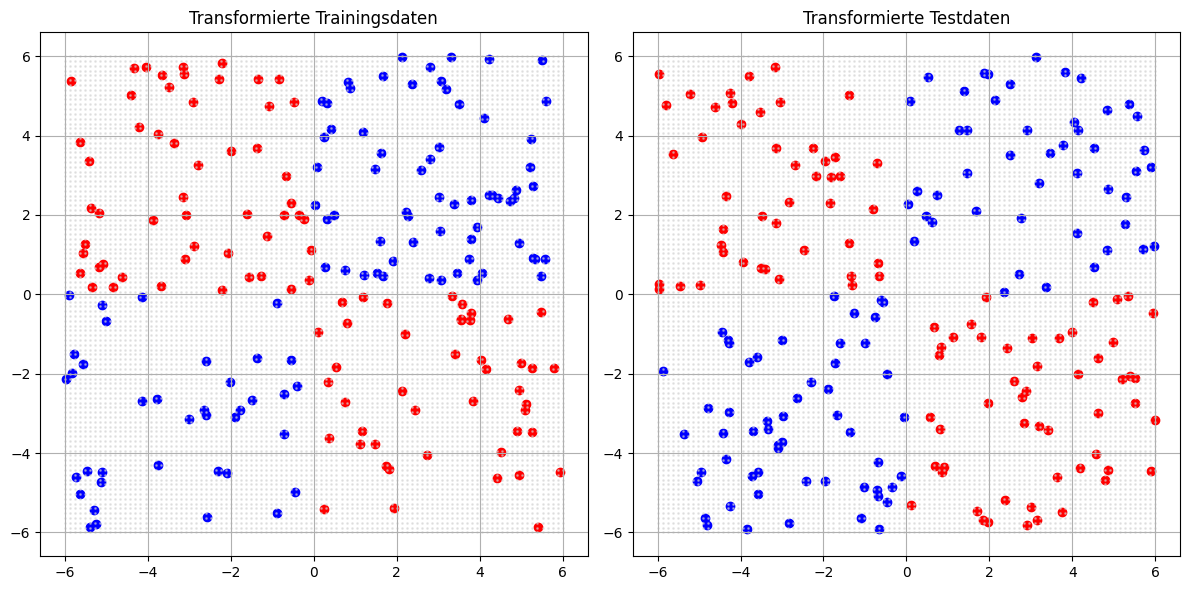

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
# Plot der transformierten Trainingsdaten
plt.subplot(1, 2, 1)
plt.title("Transformierte Trainingsdaten")
plt.scatter(design_X_train[y_train == 1, 0], design_X_train[y_train == 1, 1], color='blue', label='Label 1')
plt.scatter(design_X_train[y_train == 0, 0], design_X_train[y_train == 0, 1], color='red', label='Label 0')
plt.scatter(design_grid[:, 0], design_grid[:, 1], color='lightgray', s=1, alpha=0.5)
plt.grid()
# Plot der transformierten Testdaten
plt.subplot(1, 2, 2)
plt.title("Transformierte Testdaten")
plt.scatter(design_X_test[y_test == 1, 0], design_X_test[y_test == 1, 1], color='blue', label='Label 1')
plt.scatter(design_X_test[y_test == 0, 0], design_X_test[y_test == 0, 1], color='red', label='Label 0')
plt.scatter(design_grid[:, 0], design_grid[:, 1], color='lightgray', s=1, alpha=0.5)
plt.grid()
plt.tight_layout()
plt.show()